# Assignment 5:
# K-means and Principal Component Analysis

## Introduction

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. 
In the second part, you will learn about and use principal component analysis to find a low-dimensional representation of face images. 

In [10]:
import os

import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

import utils

# auto reload external modules
%load_ext autoreload 
%autoreload 2

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# grader object
grader=utils.Grader()

# SET YOUR Authentication Token. To get the token login to http://evalml.da.private.hm.edu/ and check the User info menu item.
AUTH_TOKEN = "cd4a9aa7782d5a61a41c6dd48746e426d1f9a09a"
grader.setToken(AUTH_TOKEN)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Submission and Grading


In the following table you will find the overview over the different tasks that you need to perform along with the points you can get:


| Section | Part                                             | Submitted Function                | Points |
| :-      |:-                                                |:-                                 | :-:    |
| 1       | [Find Closest Centroids](#section1)              | [`identifyClosestCentroids`](#identifyClosestCentroids)  |  15    |
| 2       | [Computed Centroid Means](#section2)             | [`computeCentroids`](#computeCentroids)      |  15    |
| 3       | [k-means algorithm](#section3)                   | [`kmeans`](#kmeans)      |  20    |
| 4       | [Compute PCA](#section4)                         | [`pca`](#pca)                   |  20    |
| 5       | [Project Data](#section5)                        | [`projectData`](#projectData)           |  15    |
| 6       | [Recover Data](#section6)                        | [`recoverData`](#recoverData)           |  15    |
|         | Total Points                                     |                                   |100     |


You are allowed to submit your solutions multiple times. Correct results are not updated anymore.

At the end of each section, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once. They must also be re-executed everytime the submitted function is updated.

## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. k-means clustering minimizes within-cluster variances (squared Euclidean distances).

Concretely, suppose you are given a training set $\{x_{1} , \cdots, x_m\}$ (where $x_{i} \in \mathbb{R}^n$), and want to group the data into a few “clusters”. The iterative algorithm starts with initialised centroids (either using a random initialized cluster or by prior knowledge), and then refines the clusters by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

<a id="section1"></a>
#### 1.1.1 Identify closest centroids

In the assignment phase of K-means, the algorithm assigns every training example $x_{i}$ to its closest centroid, given the current centroid estimates. Specifically, for every example $i$ we set

$$c_i := j \quad \text{that minimizes} \quad \lvert\rvert x_{i} - \mu_j  \lvert\rvert^2, $$

where $c_{i}$ is the index of the centroid that is closest to $x_{i}$, and $\mu_j$ is the position (value) of the $j_{th}$ centroid. Note that $c_{i}$ corresponds to `cidx[i]` in the starter code.

You should now complete the function `identifyClosestCentroids`. This function takes the data `X` and the locations of all centroids inside `centroids` and outputs a one-dimensional array `cidx` holding the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
<a id="identifyClosestCentroids"></a>

In [11]:
def identifyClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        
    centroids : array_like
        Centroids of size (K, n). K is the number of clusters, and n is the the data dimension.
    
    Returns
    -------
    cidx : array_like
        A vector of size (m, ) of indices identifying the closest centroids assignment for each example (row) in the dataset X.
    
    """
    
    # Set the number of clusters from centroids
    K = centroids.shape[0] # K ist die Anzahl der Zentroiden (Cluster) mit dem shape(=Anzahl der Zeilen) von centroids
    # Was macht das .shape[0]? --> Anzahl der Zeilen von centroids wird in K gespeichert

    # Set and return the following variables correctly.
    cidx = np.zeros(X.shape[0], dtype=int) # index mit länge der Anzahl der Zeilen von X

    # loop over every example, identify its closest centroid, and store the index in the idx array
    # ====================== YOUR CODE HERE ==========================
    for i in range(X.shape[0]):          # .shape[0] gibt Anzahl der Spaltem an
        minimum_distance = float('inf')  # Startwert unendlich (wird immer kleiner)
        closest_centroid = -1            # Fehlerwert 

        for j in range(K):                                # schleife über jeden Centroid und dabei vergleich mit jedem X
            distance = np.sum((X[i] - centroids[j]) ** 2) # berechnet die Distanz zwischen X und Centroid mithilfe der euklidischen Norm
            if distance < minimum_distance:               # wenn die Distanz kleiner ist als die kürzeste Distanz
                minimum_distance = distance               # speichert die kürzeste Distanz
                cidx[i] = j                               # speichert den Index des Centroids, der am nächsten ist

    # ================================    
    return cidx

In the following you can test your implementation in `findClosestCentroids`. You you should see the indices `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [12]:
# Load an example dataset
data = np.genfromtxt('Data/data_kmeans.csv', delimiter=',') # Lädt die Daten aus der csv-Datei
X = data[1:,0:2]                                            # X sind die Daten ohne die erste Zeile und ohne die letzte Spalte    

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[500, 340], [500, 300], [700, 300]]) # 3 Centroids mit den Koordinaten

# Find the closest centroids for the examples using the initial_centroids
cidx = identifyClosestCentroids(X, initial_centroids) # cidx ist Array mit den Indizes der Centroids, die am nächsten sind

print('Closest centroids for the sample with indices 50, 150 and 250')
print(cidx[50], cidx[150], cidx[250])
print('(the closest centroids should be 0, 2, 2 respectively)')

Closest centroids for the sample with indices 50, 150 and 250
0 2 2
(the closest centroids should be 0, 2, 2 respectively)


#### Submission
You should now submit your solutions by executing the following cell.

In [14]:
# appends the implemented function to the grader object
grader.setFunc("identifyClosestCentroids", identifyClosestCentroids)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |   0 /  15 | wrong
                          k-means algorithm |   0 /  20 | wrong
                                Compute PCA |   0 /  20 | wrong
                               Project Data |   0 /  15 | wrong
                               Recover Data |   0 /  15 | wrong
                                  --------------------------------
                                            |  15 / 100 | 



<a id="section2"></a>
### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x_{i}$$

where $C_k$ is the set of examples that are assigned to centroid $k$.

You should now complete the function `computeCentroids`.

Notes:
* Using vectorized implementation using numpy makes your code much faster.
<a id="computeCentroids"></a>

In [15]:
def computeCentroids(X, cidx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        
    cidx : array_like
        A vector of size (m, ) of indices identifying the closest centroids assignment for each example (row) in the dataset X.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        Centroids of size (K, n). K is the number of clusters, and n is the the data dimension.
    

    """
    # Some useful variables
    m, n = X.shape # m ist die Anzahl der Zeilen von X, n ist die Anzahl der Spalten von X

    # Set and return the following variables correctly.
    centroids = np.zeros((K, n)) # K ist die Anzahl der Zentroiden (Cluster) und n ist die Anzahl der Spalten von X

    # Compute the mean (centroid) of each cluster (by using the previous indices) 
    # ====================== YOUR CODE HERE ======================
    for i in range(K):
        # Liste der zugehörigen Punkte zu einem Centroid
        associated_points = []
        # Schleife über alle Punkte und speichert die Punkte, die zum i-ten Centroid gehören
        for j in range(m): 
            if cidx[j] == i:                   # Wenn der Index des Centroids gleich i ist
                associated_points.append(X[j]) # Füge den Punkt zu der Liste der zugehörigen Punkte hinzu

        # Berechnung des Mittelwertes der zugehörigen Punkte
        if associated_points:                            # Wenn die Liste der zugehörigen Punkte nicht leer ist
            cluster_points = np.array(associated_points) # Liste der zugehörigen Punkte in ein Array umwandeln
            mean = np.mean(cluster_points, axis=0)       # Mittelwert der zugehörigen Punkte berechnen
            centroids[i] = mean                          # Mittelwert in die Centroiden speichern
        
    
    # =============================================================
    return centroids 

Test your implementation of `computeCentroids` in the following cell.

In [16]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, cidx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 504.76702883 389.8759774 ]')
print('   [ 581.34234409 263.83096336 ]')
print('   [ 643.75470437 325.33059163 ]')

Centroids computed after initial finding of closest centroids:
[[504.76702883 389.8759774 ]
 [581.34234409 263.83096336]
 [643.75470437 325.33059163]]

The centroids should be
   [ 504.76702883 389.8759774 ]
   [ 581.34234409 263.83096336 ]
   [ 643.75470437 325.33059163 ]


#### Submission
*You should now submit your solutions.*

In [17]:
# appends the implemented function to the grader object
grader.setFunc("computeCentroids", computeCentroids)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |  15 /  15 | Nice work!
                          k-means algorithm |   0 /  20 | wrong
                                Compute PCA |   0 /  20 | wrong
                               Project Data |   0 /  15 | wrong
                               Recover Data |   0 /  15 | wrong
                                  --------------------------------
                                            |  30 / 100 | 



### 1.2 K-means on example dataset 

You have implemented the two main functions of the k-means algorithm (`identifyClosestCentroids` and `computeCentroids`), you have all the necessary pieces to run the K-means algorithm. 
The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. This local optimum solution is not always ideal and depends strongly on the initial setting of the centroids. In practice it is common to initialize the K-means algorithm with different random initializations. At the end you could choose the one result which gives you the lowest cost function.


In [18]:
def kMeans(X, centroids, identifyClosestCentroids, computeCentroids,
              max_iters=10):
    """
    Runs the K-means algorithm.

    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        
    centroids : array_like
        Centroids of size (K, n). K is the number of clusters, and n is the the data dimension.

    identfyClosestCentroids : func
        The previously implemented identfyClosestCentroids function

    computeCentroids : func
        The previously implemented computeCentroids function

    max_iters : int, optional
        Specifies the total number of interactions of K-Means to execute.

    Returns
    -------
    centroids : array_like
        Centroids of size (K, n). K is the number of clusters, and n is the the data dimension.

    idx : array_like
        A vector of size (m,) for cluster assignment for each example in the dataset. Each entry
        in idx is within the range [0 ... K-1].
    """
    
    K = centroids.shape[0] # need to compute this
    cidx = [] # need to compute this
    cidx_history = [] # here you need to append all idx for plotting
    centroid_history = [] # here you need to append all centroids for plotting

    # ====================== YOUR CODE HERE ======================
    for i in range(max_iters):                        # Schleife über die Anzahl der Iterationen
        cidx = identifyClosestCentroids(X, centroids) # Bestimmt die Zugehörigkeit der Punkte zu den Centroiden
        centroids = computeCentroids(X, cidx, K)      # Berechnet die neuen Centroiden
        cidx_history.append(cidx)                     # Speichert die Zugehörigkeit der Punkte zu den Centroiden
        centroid_history.append(centroids)            # Speichert die Centroiden
       
    # =============================================================

    return centroids, cidx, cidx_history, centroid_history

Next cell will test your implementation of `kMeans` and outputs an animation showing the iterations of kmeans. In iteration 10 you should see the following result.

![](Figures/kmeans.png)

Check also the resulting centroids after 10 iterations at the end of the code block.


Centroids computed after 10 iterations should be:
[[480.60429976 385.44506433]
 [637.26607797 399.3318376 ]
 [626.0335445  263.37338614]]

The centroids should be
   [ 480.60429976 385.44506433 ]
   [ 637.26607797 399.3318376 ]
   [ 626.0335445  263.37338614 ]


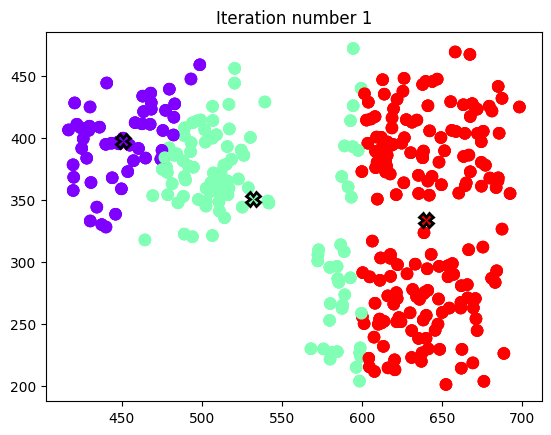

In [19]:
# Load an example dataset
data = np.genfromtxt('Data/data_kmeans.csv', delimiter=',')
X = data[1:,0:2]

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random samples from the dataset.
initial_centroids = np.array([[400, 340], [500, 300], [700, 300]])


# Run K-Means algorithm. 
centroids, idx, idx_history, centroid_history = kMeans(X, initial_centroids,
                                       identifyClosestCentroids, computeCentroids, max_iters)



fig = pyplot.figure()
anim = FuncAnimation(fig, utils.plotProgresskMeans,
                        frames=max_iters,
                        interval=500,
                        repeat_delay=2,
                        fargs=(X, centroid_history, idx_history))


print('Centroids computed after 10 iterations should be:')
print(centroids)
print('\nThe centroids should be')
print('   [ 480.60429976 385.44506433 ]')
print('   [ 637.26607797 399.3318376 ]')
print('   [ 626.0335445  263.37338614 ]')

anim

#### Submission
*You should now submit your solutions.*

In [20]:
# appends the implemented function to the grader object
grader.setFunc("kMeans", kMeans)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |  15 /  15 | Nice work!
                          k-means algorithm |  20 /  20 | Nice work!
                                Compute PCA |   0 /  20 | wrong
                               Project Data |   0 /  15 | wrong
                               Recover Data |   0 /  15 | wrong
                                  --------------------------------
                                            |  50 / 100 | 



### 1.4 Image compression with K-means (optional, ungraded)

In this exercise, you will apply K-means to image compression. We will use the image (size 320x480 pixels) below as an example.

![](Figures/photo-women_small.png)

Commonly each color pixel intensity value of an image is represented with 24 bits, i.e. three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values (RGB encoding). This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors. You will just use your implemneted kMeans algorithm for that.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the `identifyClosestCentroids` function. This allows you to represent the original image using the centroid assignments of each pixel. 
To get more concrete how much you reduce: The original image required 24 bits for each of the x128 pixels, resulting in total size of 320 x 480 x 24 = 3,686,400 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 320 x 480 x 4 = 614,784  bits, which corresponds to compressing the original image by about a factor of approx. 6.

Run the following cell to compute the centroids and the centroid allocation of each pixel in the image. You should see the original image beside the compressed image

Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

In [21]:
# # ======= Experiment with these parameters ================
# # You should try different values for those parameters
# K = 16
# max_iters = 10

# # Load an image
# A = mpl.image.imread(os.path.join('Figures', 'photo-women_small.png'))
# # ==========================================================

# # Normalize to 0..1
# A /= 255

# # Reshape the image into an Nx3 matrix where N = number of pixels.
# X = A.reshape(-1, 3)

# # Take the K random samples as initial centroids
# randidx = np.random.permutation(X.shape[0])
# initial_centroids = X[randidx[:K], :]


# # Run K-Means
# centroids, idx, hist_centr, hist_idx = kMeans(X, initial_centroids,
#                                  identifyClosestCentroids,
#                                  computeCentroids,
#                                  max_iters)

# # Recover the data based on the K centroids only
# X_recovered = centroids[idx, :].reshape(A.shape)

# # Display the original image, rescale back by 255
# fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(A*255)
# ax[0].set_title('Original')
# ax[0].grid(False)

# # Display compressed image, rescale back by 255
# ax[1].imshow(X_recovered*255)
# ax[1].set_title('Compressed, with %d colors' % K)
# ax[1].grid(False)

KeyboardInterrupt: 

No submission needed here.

## 2 Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. After working with some toy data we will later use this to create an efficient embedding for faces (eigenfaces).

### 2.1 Example Dataset

The cell below load a our well-known dataset from the first assignment. Note that this time there are no labels, we just threat the two dimensions as features.

In the following you reduce the 2 dimensional dataset to only 1 dimension. 

Notes:
* More realistic problems in practive need to reduce say 10.000 dimensions to 3 dimensions for visualization or from 10.000 to 20 dimensions for an efficient feature embedding.

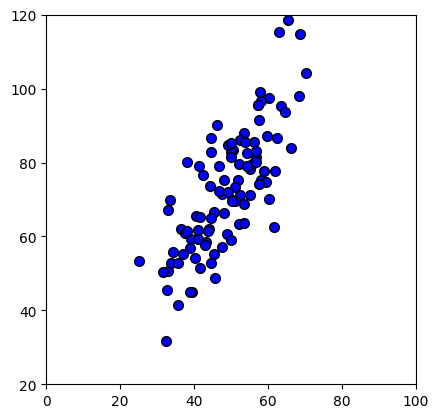

In [22]:
# Load the dataset into the variable X 
X_pca = np.genfromtxt('Data/data_pca.csv', delimiter=',')

#  Visualize the example dataset
pyplot.plot(X_pca[:, 0], X_pca[:, 1], 'bo', ms=7, mec='k', mew=1)
pyplot.grid(False)
pyplot.axis([0, 100, 20, 120])
pyplot.gca().set_aspect('equal')

<a id="section3"></a>
### 2.2 Implementing PCA

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: 

1. Compute the covariance matrix of the data.
2. Use SVD (in python you might wanna use `np.linalg.svd` for this) to compute the eigenvectors $U_1$, $U_2$, $\dots$, $U_n$  (or alternatively, $V_1$, $V_2$, $\dots$, $V_n$, since for symmetric matrices as our sample covariance this is the same). These will correspond to the principal components of variation in the data.

First, you should compute the covariance matrix of the data, which is given by:

$$ \Sigma = \frac{1}{m-1} \bar{X}^T \bar{X}$$

where $\bar{X}$ is the normalized data matrix (normalization is provided below) with examples in rows, and $m$ is the number of examples. Note that $\Sigma$ is a $n \times n$ matrix and not the summation operator. 

After computing the covariance matrix, you can run SVD on it to compute the principal components.

Now complete the code of the function `pca`.
<a id="pca"></a>

In [38]:
def pca(X_pca):
    """
    Run principal component analysis.
    
    Parameters
    ----------
    X : array_like
        The dataset to be used for computing PCA. It has dimensions (m x n)
        where m is the number of examples (observations) and n is 
        the number of features.
    
    Returns
    -------
    U : array_like
        The eigenvectors, representing the computed principal components
        of X. U has dimensions (n x n) where each column is a single 
        principal component. 
    
    S : array_like
        A vector of size n, contaning the singular values for each
        principal component. Note this is the diagonal of the matrix we 
        mentioned in class.
    
    Instructions
    ------------
    You should first compute the covariance matrix. Then, you
    should use the "svd" function to compute the eigenvectors
    and eigenvalues of the covariance matrix. 

    Notes
    -----
    When computing the covariance matrix, remember to divide by m (the
    number of examples).
    """
    # Useful values
    m, n = X_pca.shape

    # You need to return the following variables correctly.
    U = np.zeros(n)
    S = np.zeros(n)

    # ====================== YOUR CODE HERE ======================
    Sigma = (1 / (m-1)) * np.dot(X_pca.T, X_pca) # Berechnet die Kovarianzmatrix
    U, S, V = np.linalg.svd(Sigma)               # U: Eigenvector, S: Singular Value, V: Eigenwert
    
    # ============================================================
    return U, S

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

With the following cell you can test your PCA implementation. You should also see a simlar plot like this, showing the two eigenvectors.

![](Figures/pca_pcs.png)


The following cell will also output the top principal component (eigenvector) found, and you should expect to see an output of about `[-0.707 -0.707]`. (It is possible that `numpy` may instead output the negative of this, since $U_1$ and $-U_1$ are equally valid choices for the first principal component.)

Top eigenvector: U[:, 0] = [-0.707107 -0.707107]
 (you should expect to see [-0.707107 -0.707107])


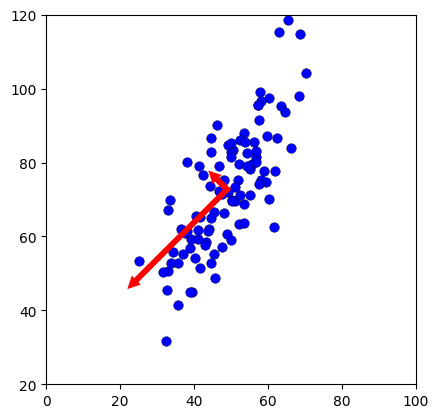

In [39]:
# Before running PCA, it is important to first normalize X
# normalization is done by substracting the mean from the data and dividing by the standard deviation.
# Note: You need to use the mean and the sigma later again. 
X_norm, mu, sigma = utils.featureNormalize(X_pca)

#  Run PCA
U, S = pca(X_norm)

#  Draw the eigenvectors centered at mean of data. These lines show the
#  directions of maximum variations in the dataset.
fig, ax = pyplot.subplots()
ax.plot(X_pca[:, 0], X_pca[:, 1], 'bo', ms=7, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 20 * S[i]*U[0, i], 20 * S[i]*U[1, i],
             head_width=1, head_length=1, fc='k', ec='r', lw=4, zorder=1000)

ax.axis([0, 100, 20, 120])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))
print(' (you should expect to see [-0.707107 -0.707107])')

#### Submission
*You should now submit your solutions.*

In [40]:
# appends the implemented function to the grader object
grader.setFunc("pca", pca)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |  15 /  15 | Nice work!
                          k-means algorithm |  20 /  20 | Nice work!
                                Compute PCA |  20 /  20 | Nice work!
                               Project Data |  15 /  15 | Nice work!
                               Recover Data |  15 /  15 | Nice work!
                                  --------------------------------
                                            | 100 / 100 | 



### 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional subspace (embedding), $x_i \rightarrow z_i$ (here: projecting the data from 2D to 1D). It might be beneficial for some learing algorithms as e.g. linear regression, logistic regresion or also neural networks, to use such an embedding instead of the original data. 

<a id="section4"></a>

#### 2.3.1 Projecting the data onto the principal components

You should now complete the code in the function `projectData`. Specifically, you are given a dataset `X`, the principal components `U`, and the desired number of dimensions to reduce to `K`. You should project each example in `X` onto the top `K` components in `U`. Note that the top `K` components in `U` are given by
the first `K` columns of `U`, that is `Ureduce = U[:, :K]`.
<a id="projectData"></a>

In [27]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only 
    on to the top K eigenvectors.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). The dataset is assumed to be 
        normalized.
    
    U : array_like
        The computed eigenvectors using PCA. This is a matrix of 
        shape (n x n). Each column in the matrix represents a single
        eigenvector (or a single principal component).
    
    K : int
        Number of dimensions to project onto. Must be smaller than n.
    
    Returns
    -------
    Z : array_like
        The projects of the dataset onto the top K eigenvectors. 
        This will be a matrix of shape (m x k).
    
    Instructions
    ------------
    Compute the projection of the data using only the top K 
    eigenvectors in U (first K columns). 

    """
    # You need to return the following variables correctly.
    Z = np.zeros((X.shape[0], K))

    # ====================== YOUR CODE HERE ======================
    U_reduce = U[:, :K]     # Reduziert die Anzahl der Dimensionen auf K
    Z = np.dot(X, U_reduce) # Berechnet die Projektion der Daten auf die ersten K Eigenvektoren
    
    
    # =============================================================
    return Z

Once you have completed the code in `projectData`, the following cell will project the first example onto the first dimension and you should see a value of about 2.935453.

In [28]:
#  Project the data onto K = 1 dimension
K = 1
Z = projectData(X_norm, U, K)
print('Projection of the first example: {:.6f}'.format(Z[0, 0]))
print('(this value should be about    : 2.935453)')

Projection of the first example: 2.935453
(this value should be about    : 2.935453)


#### Submission
*You should now submit your solutions.*

In [29]:
# appends the implemented function to the grader object
grader.setFunc("projectData", projectData)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |  15 /  15 | Nice work!
                          k-means algorithm |  20 /  20 | Nice work!
                                Compute PCA |  20 /  20 | Nice work!
                               Project Data |  15 /  15 | Nice work!
                               Recover Data |   0 /  15 | wrong
                                  --------------------------------
                                            |  85 / 100 | 



<a id="section5"></a>
#### 2.3.2 Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Your task is to complete the function `recoverData` to project each example in `Z` back onto the original space and return the recovered approximation in `Xrec`.
<a id="recoverData"></a>

In [30]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the 
    projected data.
    
    Parameters
    ----------
    Z : array_like
        The reduced data after applying PCA. This is a matrix
        of shape (m x K).
    
    U : array_like
        The eigenvectors (principal components) computed by PCA.
        This is a matrix of shape (n x n) where each column represents
        a single eigenvector.
    
    K : int
        The number of principal components retained
        (should be less than n).
    
    Returns
    -------
    X_rec : array_like
        The recovered data after transformation back to the original 
        dataset space. This is a matrix of shape (m x n), where m is 
        the number of examples and n is the dimensions (number of
        features) of original datatset.
    
    Instructions
    ------------
    Compute the approximation of the data by projecting back
    onto the original space using the top K eigenvectors in U.
    Notice that U[j, :K] is a vector of size K.
    """
    # You need to return the following variables correctly.
    X_rec = np.zeros((Z.shape[0], U.shape[0]))

    # ====================== YOUR CODE HERE ======================
    U_reduce = U[:, :K]           # Reduziert die Anzahl der Dimensionen auf K
    X_rec = np.dot(Z, U_reduce.T) # Berechnet die Projektion der Daten auf die ersten K Eigenvektoren
    

    # =============================================================
    return X_rec

Once you have completed the code in `recoverData`, the following cell will recover an approximation of the first example and you should see a value of about `[-2.075679 -2.075679]`. The code will then plot the data in this reduced dimension space. This will show you what the data looks like when using only the corresponding eigenvectors to reconstruct it. An example of what you should get for PCA projection is shown in this figure: 

![](Figures/pca_recover.png)

In the figure above, the original data points are indicated with the blue circles, while the projected data points are indicated with the red circles. The projection effectively only retains the information in the direction given by $U_1$. The dotted lines show the distance from the data points in original space to the projected space. Those dotted lines represent the error measure due to PCA projection.

Approximation of the first example: [-2.075679 -2.075679]
       (this value should be about  [-2.075679 -2.075679])


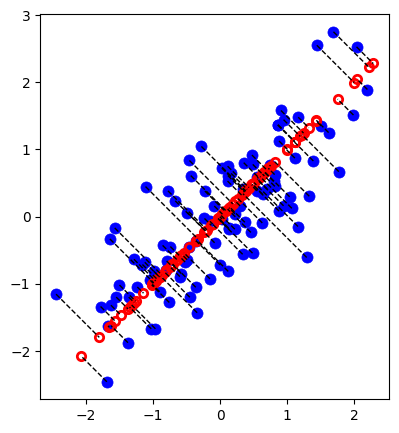

In [31]:
X_rec  = recoverData(Z, U, K)
print('Approximation of the first example: [{:.6f} {:.6f}]'.format(X_rec[0, 0], X_rec[0, 1]))
print('       (this value should be about  [-2.075679 -2.075679])')

#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = pyplot.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

#### Submission
*You should now submit your solutions.*

In [32]:
# appends the implemented function to the grader object
grader.setFunc("recoverData", recoverData)
newfunc = grader.grade()

                 Identify Closest Centroids |  15 /  15 | Nice work!
                    Computed Centroid Means |  15 /  15 | Nice work!
                          k-means algorithm |  20 /  20 | Nice work!
                                Compute PCA |  20 /  20 | Nice work!
                               Project Data |  15 /  15 | Nice work!
                               Recover Data |  15 /  15 | Nice work!
                                  --------------------------------
                                            | 100 / 100 | 



### 2.4 Face Image Dataset (Optional, not graded)

This part will only run when you wrote your functions above correctly ;-). You will not get a grade for this, but I think it is still worth to check this out. 
In the following we will work with a well-known Face dataset: C. Sanderson, B.C. Lovell. "Multi-Region Probabilistic Histograms for Robust and Scalable Identity Inference." ICB 2009, LNCS 5558, pp. 199-208, 2009., <a href=https://conradsanderson.id.au/lfwcrop/>Link</a>. 
This dataset contains 12.233 faces of well-known persons.
In the npy pickle that we will load in the next cell, the dataset has been pre-processed and each image was scaled to to 32x32 pixels. 
We will apply your PCA methods on this dataset and create a feature embedding wich we will later also use for face recognition.

![Faces](Figures/pca_faces.png)

(1024,)


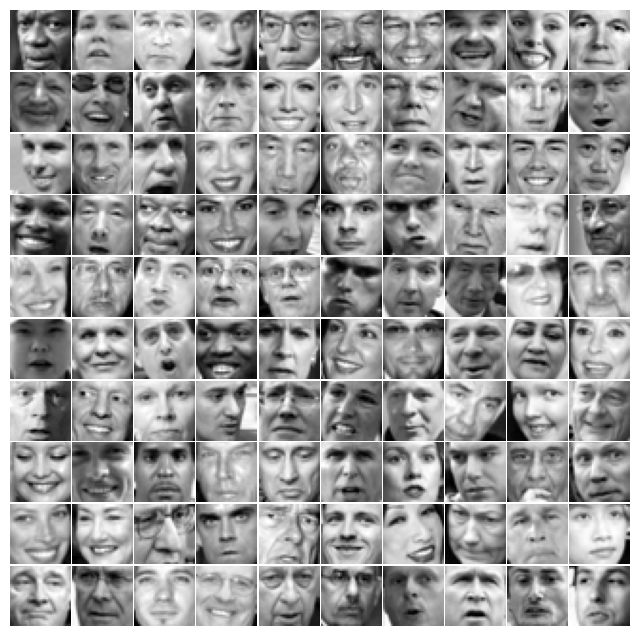

In [33]:
#  Load Face dataset
X_faces = np.load('Data/data_faces.npy', allow_pickle=True)
print(X_faces[1, :].shape)

#  Display the first 100 faces in the dataset
utils.displayData(X_faces[:100, :], figsize=(8, 8))

#### 2.4.1 PCA on Faces

To run PCA on the face dataset, we first normalize the dataset again.  After running PCA then, you will obtain the principal components of the dataset. Notice that each principal component in `U` (each column) is a vector of length $n$ (where for the face dataset, $n = 1024$ since we flattend the dimensions from the images 32x32 to 1024). You can visualize the principal components by reshaping each of them into a $32 \times 32$ matrix again, i.e. the size of images in the dataset. 

The following cell will use the first 64 principal components (called `eigenfaces`) that describe the largest variations are displayed.

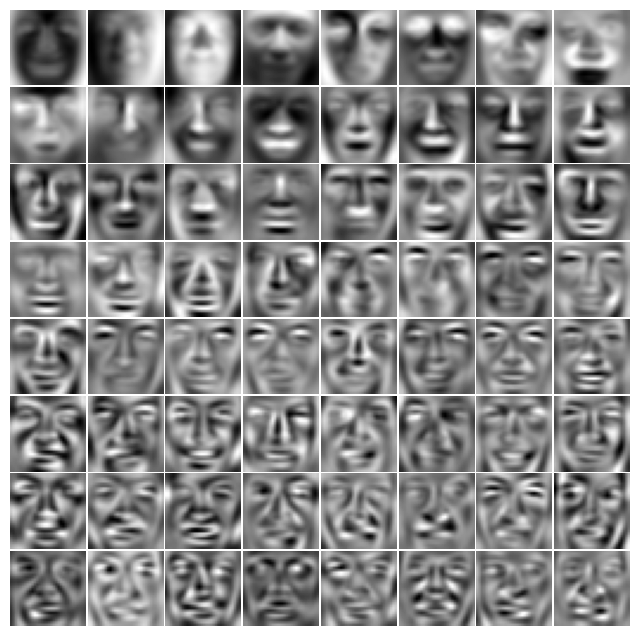

In [34]:
#  normalize X by subtracting the mean value from each feature
X_faces_norm, mu_faces, sigma_faces = utils.featureNormalize(X_faces)

#  Run PCA
U_faces, S_faces = pca(X_faces_norm)

#  Visualize the top 36 eigenvectors found
utils.displayData(U_faces[:, :64].T, figsize=(8, 8))

#### 2.4.2 Dimensionality Reduction

Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm - especially in preventing overfitting.

The next cell will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector $z_i \in \mathbb{R}^{100}$. To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset.

In [35]:
#  Project images to the eigen space using the top k eigenvectors 
#  If you are applying a machine learning algorithm 
K = 100
Z_faces = projectData(X_faces_norm, U_faces, K)

print('The projected data Z has a shape of: ', Z_faces.shape)

The projected data Z has a shape of:  (13230, 100)


In the next cell, an approximate recovery of the data is performed and the original and projected face images
are displayed similar to what is shown here:

<table>
    <tr>
        <td><img src="Figures/pca_faces.png" width="300"></td>
        <td><img src="Figures/pca_faces_recover.png" width="300"></td>
    </tr>
</table>

From the reconstruction, you can observe that the general structure and appearance of the face are kept while the fine details are lost. This is a remarkable reduction (more than 10x) in the dataset size that can help speed up your learning algorithm significantly. For example, if you were training a neural network to perform person recognition (given a face image, predict the identity of the person), you can use the dimension reduced input of only a 100 dimensions instead of the original pixels.

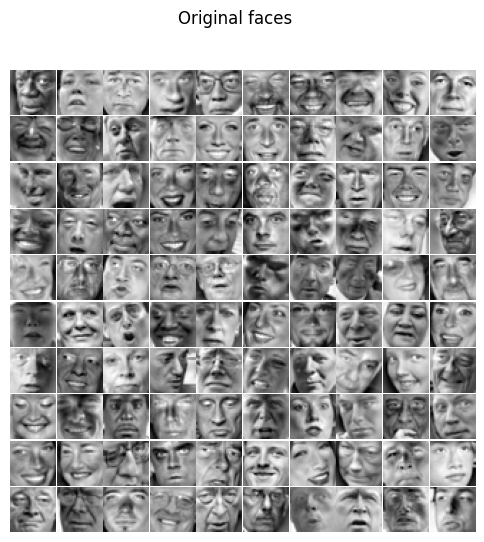

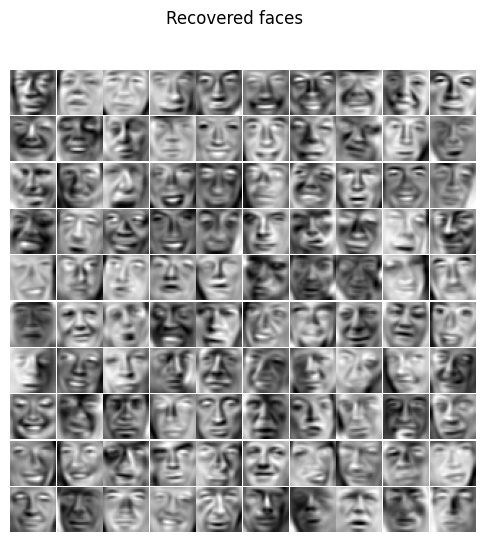

In [36]:
#  Project images to the eigen space using the top K eigen vectors and 
#  visualize only using those K dimensions
#  Compare to the original input, which is also displayed
K = 100
X_faces_rec  = recoverData(Z_faces, U_faces, K)

# Display normalized data
utils.displayData(X_faces_norm[:100, :], figsize=(6, 6))
pyplot.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
utils.displayData(X_faces_rec[:100, :], figsize=(6, 6))
pyplot.gcf().suptitle('Recovered faces')
pass

#### 2.4.2 Face recognition
Now let's load a test image and let's try to identify the closest face in our training dataset. For this we transform both, the trainnig images and the test image into the same subspace using the `projectData` method. We reuse our alread computed PCs for that.


13230


Text(0.5, 0.98, 'Closest matches')

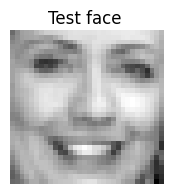

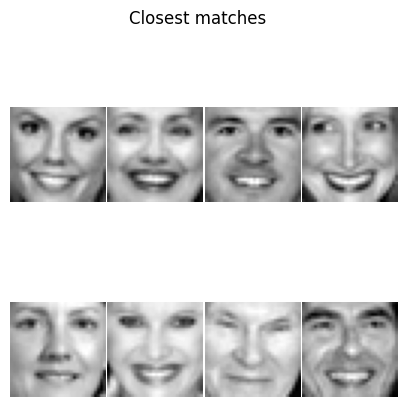

In [37]:
import cv2
# load a test image and normalize this image using the same mean and sigma
X_face_test = cv2.resize(cv2.imread("Data/lfwcrop_grey/testfaces/Hillary_Clinton_0009.pgm", cv2.IMREAD_GRAYSCALE), (32,32)).T.flatten()
X_face_test_norm = X_face_test - mu_faces
X_face_test_norm /= sigma_faces

#  Run PCA on the test image
K = 100
Z_faces_train = projectData(X_faces_norm, U_faces, K)
Z_face_test = projectData(X_face_test_norm, U_faces, 100)

# Distance to all points in B, for each point in A.
def euclid_dist(t1, t2):
    return np.sqrt(((t1-t2)**2).sum(axis = 1))

# compute the distance of our projected test image to all projected train images
dist = euclid_dist(Z_face_test, Z_faces_train)
print(len(dist))

# Get the indices of the 8 closest matches
result = np.argpartition(dist, 8)

#print(min_dist_idx)
utils.displayData(X_face_test, figsize=(2, 2))
pyplot.gcf().suptitle('Test face')

utils.displayData(X_faces[result[:8]], figsize=(5, 5))
pyplot.gcf().suptitle('Closest matches')

While the results are not perfect, at least "close" faces having a similar facial expression are returned from the set of 13.233! images. Note that we just use a simple euclidean distance for that. This will not work on the original image dimensions of 1024, since feature values contain to much entropy. Note also that using some more sophisticated methods (that we discussed already) might produce much better results than the simple euclidean distance.

## 3 Uploading your PDF
Well done. You are now ready with this assignment. 
Please make sure that ALL code cells are executed and create a PDF from the notebook: Use the File-->Print... function in Juypter Lab (not via the Browser, and not export as PDF in Jupyter Lab).
Upload this PDF to Moodle in the assignment section and in the correct assignment number.

## 4 References
* Face dataset: C. Sanderson, B.C. Lovell. "Multi-Region Probabilistic Histograms for Robust and Scalable Identity Inference." ICB 2009, LNCS 5558, pp. 199-208, 2009., <a href=https://conradsanderson.id.au/lfwcrop/>Link</a>
* Kmeans toy data from <a href=https://www.kaggle.com/code/samuelcortinhas/k-means-from-scratch/data>Kaggle (Samuel Cortinhas)</a>
* Kmeans compression photo by <a href="https://unsplash.com/@corey_saldana?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Corey Saldana</a> on <a href="https://unsplash.com/s/photos/women-fashion?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
* This Notebook and the python code has been inspired and partly adapted from: Andrew Ng, Machine Learning CS229/Coursera (course and assignments).

  